# 100 Years of Baseball

### Imports

In [131]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.cm as cm
import umap.umap_ as umap
from IPython.display import Markdown

## Data Loading

Unfortunately, the original dataset I planned to work with was improperly assembled from the raw csv files, resulting in many missing rows. I still like the column names, so we will use those from that csv, but we will build the DataFrame from scratch using the individual year game log files. Assembling the dataset like this is fairly computationally expensive, so the folowing code has been commented out, and the assembled dataset is loaded from github. The raw csvs used can be found here: [Retrosheet](https://retrosheet.org/gamelogs/). 

In [3]:
# data_dir = './data'

In [4]:
# col_names = pd.read_csv(os.path.join(data_dir, 'game_logs.csv'), nrows=0).columns
# col_names

In [5]:
# data_raw = pd.DataFrame()

# for year in range(1871, 2024):
#     year_df = pd.read_csv(f"./data/gl1871_2023/gl{str(year)}.txt", header=None)
#     data_raw = pd.concat([data_raw, year_df])
    
# del year_df

# data_raw.columns = col_names

In [6]:
# data_raw['v_line_score'] = data_raw['v_line_score'].astype('str') # Parquet doesn't play nice with integer-like object types in pandas.
# data_raw['h_line_score'] = data_raw['h_line_score'].astype('str')
# data_raw.to_parquet('./public_data/MLB_gl1871_2023.parquet.gzip', compression='gzip')

In [7]:
# data_raw.info(memory_usage='deep')

## Loading Data from Github  

Our compressed parquet object is fairly small (~25 MB), so we can store it on github directly. 

In [8]:
data_raw = pd.read_parquet('https://github.com/moore-andrew05/MLB-ds/raw/main/public_data/MLB_gl1871_2023.parquet.gzip')
data_raw.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 1.1 GB


## Memory Management and Column dtypes
This object is manageable in size (~1.2GB), but we would like to reduce it. We could optimize some of our numerical columns, but we will get much more memory optimization from converting our `object` columns to `categorical`. 

The memory usage of a `Categorical` is proportional to the number of categories plus the length of the data. In contrast, an `object` dtype is a constant times the length of the data - [Pandas Documentation](https://pandas.pydata.org/docs/user_guide/categorical.html#categorical-memory). Because of this, we will use the categorical dtype only when the number of unique values is significantly smaller than the number of total values. 

In addition to this, we need to consider whether a categorical datatype makes sense for the data in each column as well as the limitations of the pandas categorical type. Mainly, categorical columns are not compatible with numpy, so we will have to take that into account. 

Here are our `object` columns:

In [9]:
pd.set_option('display.max_columns', 100)
data_obj = data_raw.select_dtypes(include=["object"]).copy()
data_obj.describe()

day_of_week  v_name v_league  h_name h_league day_night  \
count       228779  228779   227698  228779   227698    208491   
unique           7     150        6     150        6         2   
top            Sat     CHN       NL     CHN       NL         D   
freq         38137   10961   116993   11132   117005    114377   

              completion forefeit protest park_id v_line_score h_line_score  \
count                189      149     273  228779       228779       228779   
unique               189        3       5     258        49235        47812   
top     19190727,,0,2,36        H       V   BOS07          nan          nan   
freq                   1       70     134    8771        18578        18578   

       hp_umpire_id hp_umpire_name 1b_umpire_id 1b_umpire_name 2b_umpire_id  \
count        228763         228766       203923         228766       144687   
unique         1346           1340          894            893          555   
top        klemb901      Bill Klem     connt901         (none)     westj901   
freq           3544           3544         2025          24843         1326   

       2b_umpire_name 3b_umpire_id 3b_umpire_name lf_umpire_id lf_umpire_name  \
count          228143       173593         228143          208         228769   
unique            556          608            608           36             37   
top            (none)     westj901         (none)     sudoe901         (none)   
freq            83456         1398          54550           30         228561   

       rf_umpire_id rf_umpire_name v_manager_id v_manager_name h_manager_id  \
count            14         228769       228779         228779       228779   
unique           13             14          727            727          740   
top        gormt101         (none)     mackc101    Connie Mack     mackc101   
freq              2         228755         3898           3898         3846   

       h_manager_name winning_pitcher_id winning_pitcher_name  \
count          228779             207660               207660   
unique            740               6870                 6806   
top       Connie Mack           johnw102       Walter Johnson   
freq             3846                417                  417   

       losing_pitcher_id losing_pitcher_name saving_pitcher_id  \
count             207660              207660             74829   
unique              7536                7460              4283   
top             ryann001       Dutch Leonard          rivem002   
freq                 292                 295               652   

       saving_pitcher_name winning_rbi_batter_id winning_rbi_batter_id_name  \
count               208482                176417                     208482   
unique                4263                  7829                       7717   
top                 (none)              pujoa001                     (none)   
freq                133653                   328                      32065   

       v_starting_pitcher_id v_starting_pitcher_name h_starting_pitcher_id  \
count                 228735                  228735                228735   
unique                  6365                    6313                  6318   
top                 younc102              Don Sutton              younc102   
freq                     403                     375                   412   

       h_starting_pitcher_name v_player_1_id   v_player_1_name v_player_2_id  \
count                   228735        208482            208482        208482   
unique                    6276          3847              3806          4831   
top                 Nolan Ryan      hendr001  Rickey Henderson      fox-n101   
freq                       412          1447              1447           852   

       v_player_2_name v_player_3_id v_player_3_name v_player_4_id  \
count           208482        208482          208482        208482   
unique            4767          3939            3904          3485   
top         Nellie Fox     

Some columns are obvious candidates for the categorical dtype, such as `day_of_week` and `day_night`. Thinking about the content of other columns, the `v_line_score` and `h_line_score` columns stick out, as they represent the box score (runs scored in each inning by both teams). It doesn't make much sense to represent these as categorical data. I will not make extensive use of them in this analysis, but if using them, it would be best to either create a custom dtype for this data or to represent the score for each inning as its own column in the DataFrame. 

The big question mark is our player name data. The ratio of unique values to total length for these columns is about 0.03, and there are a lot of columns representating player name and id, so we will see large memory savings by converting these columns. However, we will make extensive use of these columns in network analysis, so it may be easier to work with them as object columns. For now, we will convert them to categorical. 

In [10]:
data_obj.drop(columns=['v_line_score', 'h_line_score'], inplace=True)   # Drop v_line and h_line columns
data_obj = data_obj.astype('category')                                  # Convert remaining columns to categorical 

In [11]:
data_opt = data_raw.copy()
data_opt[data_obj.columns] = data_obj
del data_obj                                                            # data_obj no longer needed

In [12]:
print('Optimized DataFrame')
print(data_opt.info(memory_usage='deep'))
print('\nOriginal DataFrame')
print(data_raw.info(memory_usage='deep'))

Optimized DataFrame
<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: category(76), float64(77), int64(6), object(2)
memory usage: 232.9 MB
None

Original DataFrame
<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 1.1 GB
None


We now have an optimized dataframe where all but 2 of our object columns have been converted to categorical dtypes. Our optimized dataframe takes up 5 times less space with this change!

The last step in cleaning our columns is our date column. This is not a memory saving measure, but we will want to convert our date to a more usable format. Luckily, Pandas gives us a tool for this, the `datetime` type. 

In [13]:
date_col = data_opt['date']
data_opt['date'] = pd.to_datetime(date_col, format="%Y%m%d")
data_opt.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 228779 entries, 0 to 2429
Columns: 161 entries, date to acquisition_info
dtypes: category(76), datetime64[ns](1), float64(77), int64(5), object(2)
memory usage: 232.9 MB


We'll also prepare some aggregate statistics for later analyses. 

In [14]:
data_opt

date  number_of_game day_of_week v_name v_league  v_game_number  \
0    1871-05-04               0         Thu    CL1      NaN              1   
1    1871-05-05               0         Fri    BS1      NaN              1   
2    1871-05-06               0         Sat    CL1      NaN              2   
3    1871-05-08               0         Mon    CL1      NaN              3   
4    1871-05-09               0         Tue    BS1      NaN              2   
...         ...             ...         ...    ...      ...            ...   
2425 2023-10-01               0         Sun    SDN       NL            162   
2426 2023-10-01               0         Sun    CLE       AL            162   
2427 2023-10-01               0         Sun    NYA       AL            162   
2428 2023-10-01               0         Sun    TEX       AL            162   
2429 2023-10-01               0         Sun    TBA       AL            162   

     h_name h_league  h_game_number  v_score  h_score  length_outs day_night  \
0       FW1      NaN              1        0        2         54.0         D   
1       WS3      NaN              1       20       18         54.0         D   
2       RC1      NaN              1       12        4         54.0         D   
3       CH1      NaN              1       12       14         54.0         D   
4       TRO      NaN              1        9        5         54.0         D   
...     ...      ...            ...      ...      ...          ...       ...   
2425    CHA       AL            162        2        1         66.0         D   
2426    DET       AL            162        2        5         51.0         D   
2427    KCA       AL            162        2        5         51.0         D   
2428    SEA       AL            162        0        1         51.0         D   
2429    TOR       AL            162       12        8         54.0         D   

     completion forefeit protest park_id  attendance  length_minutes  \
0           NaN      NaN     NaN   FOR01       200.0           120.0   
1           NaN      NaN     NaN   WAS01      5000.0           145.0   
2           NaN      NaN     NaN   RCK01      1000.0           140.0   
3           NaN      NaN     NaN   CHI01      5000.0           150.0   
4           NaN      NaN     NaN   TRO01      3250.0           145.0   
...         ...      ...     ...     ...         ...             ...   
2425        NaN      NaN     NaN   CHI12     20588.0           187.0   
2426        NaN      NaN     NaN   DET05     41425.0           148.0   
2427        NaN      NaN     NaN   KAN06     20662.0           144.0   
2428        NaN      NaN     NaN   SEA03     43997.0           121.0   
2429        NaN      NaN     NaN   TOR02     42058.0           167.0   

     v_line_score h_line_score  v_at_bats  v_hits  v_doubles  v_triples  \
0       000000000    010010000       30.0     4.0        1.0        0.0   
1       107000435    640113030       41.0    13.0        1.0        2.0   
2       610020003    010020100       49.0    11.0        1.0        1.0   
3       101403111    077000000       46.0    15.0        2.0        1.0   
4       000002232    101003000       46.0    17.0        4.0        1.0   
...           ...          ...        ...     ...        ...        ...   
2425  00000000011  00000000010       36.0     7.0        1.0        0.0   
2426    000110000    11102000x       33.0     5.0        1.0        0.0   
2427    000002000    02021000x       32.0     7.0        3.0        0.0   
2428    000000000    00010000x       30.0     4.0        1.0        0.0   
2429    170111100    030003110       43.0    16.0        4.0        0.0   

      v_homeruns  v_rbi  v_sacrifice_hits  v_sacrifice_flies  v_hit_by_pitch  \
0            0.0    0.0               0.0                0.0             0.0   
1            0.0   13.0               0.0                0.0             0.0   
2            0.0    8.0               0.0                0.0             0.0   
3            2.0   10.0    

In [15]:
data_opt['winning_margin'] = (data_opt['h_score'] - data_opt['v_score']).apply(np.abs)
data_opt['total_score'] = data_opt['h_score'] + data_opt['v_score']

In [16]:
eras_dict = {
    '1871-01-01': 'Pre-History (1871-1900)',
    '1901-01-01': 'Dead Ball Era (1901-1920)',
    '1921-01-01': 'Live Ball Era (1921-1942)',
    '1943-01-01': 'Integration Era (1943-1961)',
    '1962-01-01': 'Expansion Era (1962-1977)',
    '1978-01-01': 'Free Agent Era (1978-1994)',
    '1995-01-01': 'Steroid Era (1995-2004)',
    '2005-01-01': 'Contemporary Era (2005-Present)'
}

dates = sorted(pd.to_datetime(key) for key in eras_dict.keys())
labels = [eras_dict[str(date.date())] for date in dates]

bins = dates + [pd.Timestamp('today')]

In [17]:
# Feature Creation
aggregate_stats = ['length_outs', 'total_score', 'winning_margin', 'hits', 'doubles', 'triples', 'homeruns', 'rbi', 'walks', 'strikeouts', 'stolen_bases', 'errors', 'double_plays']

for feature in aggregate_stats[3:]:
    c1 = f'v_{feature}'
    c2 = f'h_{feature}'
    data_opt[feature] = data_opt[c1] + data_opt[c2]

era = pd.cut(data_opt['date'], bins=bins, labels=labels, right=False, include_lowest=True)
era_mapping = pd.DataFrame(era)
era_mapping.rename(columns={'date':'era'}, inplace=True)
era_mapping['date'] = data_opt['date']
era_mapping = era_mapping.drop_duplicates().set_index('date')
data_opt['era'] = era

### Home Field Advantage

In [119]:
home_field = data_opt.loc[data_opt.loc[:,'winning_margin'] != 0].copy(deep=False)

In [120]:
teams = pd.read_csv('./data/teams.csv')
teams['CITY_NICKNAME'] = teams['CITY'] + ' - ' + teams['NICKNAME'] + f' (' + teams['TEAM'] + ')'
team_league_mapper = teams.set_index('TEAM')['LEAGUE'].to_dict()
team_nickname_mapper = teams.set_index('TEAM')['CITY_NICKNAME'].to_dict()

In [184]:
parks = pd.read_csv('./data/ballparks.csv')
parks['CURRENT'] = ~parks['START'].isna() & parks['END'].isna()
parks['CITY-NAME'] = parks['CITY'] + ' - ' + parks['NAME'] + ' (' + parks['PARKID'] + ')'
parks.loc[parks['CITY-NAME'].isna(), 'CITY-NAME'] = parks['PARKID'].where(parks['CITY-NAME'].isna())
parks_mapper = parks.set_index('PARKID')['CITY-NAME'].to_dict()

In [121]:
home_field.loc[:, 'home_win'] = home_field['h_score'] > home_field['v_score']
home_field.loc[home_field['h_score'] > home_field['v_score'], 'w_team'] = home_field['h_name'][home_field['h_score'] > home_field['v_score']].astype('object')
home_field.loc[home_field['h_score'] < home_field['v_score'], 'w_team'] = home_field['v_name'][home_field['h_score'] < home_field['v_score']].astype('object')
home_field.loc[home_field['h_score'] > home_field['v_score'], 'l_team'] = home_field['v_name'][home_field['h_score'] > home_field['v_score']].astype('object')
home_field.loc[home_field['h_score'] < home_field['v_score'], 'l_team'] = home_field['h_name'][home_field['h_score'] < home_field['v_score']].astype('object')
home_field['w_team'] = home_field['w_team'].astype('category')
home_field['l_team'] = home_field['l_team'].astype('category')
home_field['w_team_league'] = home_field['w_team'].map(team_league_mapper)
home_field['l_team_league'] = home_field['l_team'].map(team_league_mapper)
home_field['w_team_nickname'] = home_field['w_team'].map(team_nickname_mapper)
home_field['l_team_nickname'] = home_field['l_team'].map(team_nickname_mapper)

In [123]:
gb_hf = home_field.set_index('date').groupby(pd.Grouper('date', freq='YE'))

<Axes: xlabel='date'>

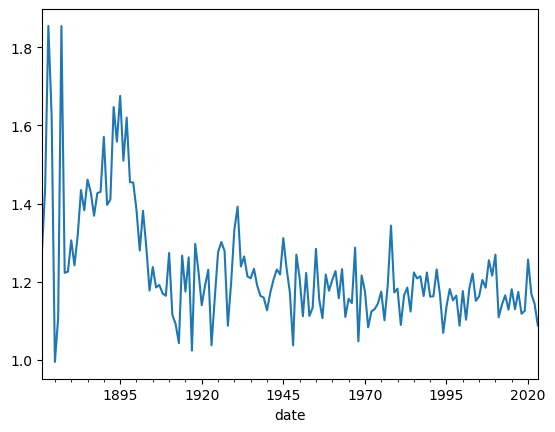

In [124]:
home_win_percentage = gb_hf['home_win'].sum() / gb_hf['home_win'].size()
visit_win_percentage = 1 - home_win_percentage
odds = home_win_percentage / visit_win_percentage
(odds).plot()

In [151]:
w_team_gb = home_field.groupby('w_team', observed=True)
l_team_gb = home_field.groupby('l_team', observed=True) 

# Home record
home_wins = w_team_gb['home_win'].sum()
home_losses = l_team_gb.size() - l_team_gb['home_win'].sum()
home_percentage = ((home_wins / (home_wins + home_losses))).where(home_wins+home_losses > 500).dropna()
home_percentage.index = home_percentage.index.map(team_nickname_mapper)
home_percentage.name = 'Home Win Percentage'
display(Markdown(home_percentage.sort_values(ascending=False).round(3)[:5].to_markdown()))
#Away Record
away_wins = w_team_gb.size() - w_team_gb['home_win'].sum()
away_losses = l_team_gb['home_win'].sum()
away_percentage = ((away_wins / (away_wins + away_losses))).where(away_wins+away_losses > 500).dropna() # Filter on teams with at least 500 games
away_percentage.index = away_percentage.index.map(team_nickname_mapper)
away_percentage.name = 'Away Win Percentage'
display(Markdown(away_percentage.sort_values(ascending=False).round(3)[:5].to_markdown()))

|                                |   Home Win Percentage |
|:-------------------------------|----------------------:|
| St. Louis - Cardinals (SL4)    |                 0.719 |
| Baltimore - Orioles (BLN)      |                 0.699 |
| Cincinnati - Reds (CN2)        |                 0.662 |
| Philadelphia - Athletics (PH4) |                 0.622 |
| New York - Yankees (NYA)       |                 0.614 |

|                             |   Away Win Percentage |
|:----------------------------|----------------------:|
| St. Louis - Cardinals (SL4) |                 0.563 |
| Milwaukee - Braves (MLN)    |                 0.533 |
| New York - Yankees (NYA)    |                 0.525 |
| Los Angeles - Dodgers (LAN) |                 0.512 |
| New York - Giants (NY1)     |                 0.504 |

In [190]:
stadium_gb = home_field.groupby('park_id', observed=True)
stadium_wins = stadium_gb['home_win'].sum()
stadium_losses = stadium_gb.size() - stadium_wins
stadium_percentage = (stadium_wins / (stadium_gb.size())).where(stadium_gb.size() > 500)
current_percentages = stadium_percentage[parks.set_index('PARKID')['CURRENT']]
stadium_percentage.index = stadium_percentage.index.map(parks_mapper)
current_percentages.index = current_percentages.index.map(parks_mapper)
stadium_percentage.name = 'Home Win Percentage'
current_percentages.name = 'Home Win Percentage'
display(Markdown(stadium_percentage.sort_values(ascending=False)[:5].to_markdown()))
display(Markdown(current_percentages.sort_values(ascending=False)[:5].to_markdown()))

| park_id                                         |   Home Win Percentage |
|:------------------------------------------------|----------------------:|
| STL03                                           |              0.698727 |
| Baltimore - Oriole Park III (BAL07)             |              0.690635 |
| Boston - South End Grounds I (BOS01)            |              0.672059 |
| Philadelphia - Columbia Park (PHI10)            |              0.664395 |
| Philadelphia - Jefferson Street Grounds (PHI01) |              0.64011  |

| park_id                               |   Home Win Percentage |
|:--------------------------------------|----------------------:|
| New York - Yankee Stadium II (NYC21)  |              0.619742 |
| Los Angeles - Dodger Stadium (LOS03)  |              0.580577 |
| St. Louis - Busch Stadium III (STL10) |              0.579473 |
| Atlanta - Truist Park (ATL03)         |              0.578641 |
| Boston - Fenway Park (BOS07)          |              0.570317 |

In [191]:
display(Markdown(current_percentages.sort_values()[:5].to_markdown()))

| park_id                                         |   Home Win Percentage |
|:------------------------------------------------|----------------------:|
| Miami - Marlins Park (MIA02)                    |              0.481928 |
| Baltimore - Oriole Park at Camden Yards (BAL12) |              0.498801 |
| Pittsburgh - PNC Park (PIT08)                   |              0.500553 |
| Detroit - Comerica Park (DET05)                 |              0.501323 |
| Cincinnati - Great American Ballpark (CIN09)    |              0.506991 |

### Umpire Advantage

In [21]:
umpire_df = data_opt.loc[:, ['date', 'hp_umpire_id', 'strikeouts', 'walks']].copy()
umpire_df[['strikeouts', 'walks']] = umpire_df[['strikeouts', 'walks']].replace(-2.0, np.nan).replace(-1.0, np.nan)
umpire_df = umpire_df.dropna()
umpire_df['hp_umpire_id'] = umpire_df['hp_umpire_id'].astype('object') # Due to the way that categories work after filtering, we don't want to deal with them here

In [23]:
gb = umpire_df.groupby('hp_umpire_id', observed=True)
umpire_mean_stats = gb[['strikeouts', 'walks']].mean()[gb.size() > 20]

In [24]:
umpire_mean_stats['first_game'] = gb['date'].min()
umpire_mean_stats['last_game'] = gb['date'].max()

In [25]:
def cohens_d(u1, s1, n1, u2, s2, n2):
    pooled_sd = np.sqrt(((n1 - 1) * np.power(s1, 2) + (n2 - 1) * np.power(s2, 2)) / (n1 + n2 - 2))
    return (u1 - u2) / pooled_sd

def calc_mean_std_size(p):
    return np.mean(p), np.std(p), len(p)

def get_populations(umpire, stat):
    p1 = umpire_df[(umpire_df['date'] >= umpire_mean_stats.loc[umpire, 'first_game']) & (umpire_df['date'] <= umpire_mean_stats.loc[umpire, 'last_game']) & (umpire_df['hp_umpire_id'] != umpire)][stat]
    p2 = umpire_df[umpire_df['hp_umpire_id'] == umpire][stat]
    return p1, p2

In [26]:
pops_strikeouts = umpire_mean_stats.index.to_series().apply(get_populations, args=('strikeouts',)) # This code is slow rn
pops_walks = umpire_mean_stats.index.to_series().apply(get_populations, args=('walks',))

In [27]:
umpire_mean_stats['effect_size_strikeouts'] = pd.Series(pd.DataFrame(pops_strikeouts.to_list()).apply(lambda x: cohens_d(*calc_mean_std_size(x[0]), *calc_mean_std_size(x[1])), axis=1)).values
umpire_mean_stats['effect_size_walks'] = pd.Series(pd.DataFrame(pops_walks.to_list()).apply(lambda x: cohens_d(*calc_mean_std_size(x[0]), *calc_mean_std_size(x[1])), axis=1)).values

In [28]:
umpire_mean_stats

strikeouts     walks first_game  last_game  \
hp_umpire_id                                               
addir901       16.841379  6.586207 2017-06-14 2023-09-24   
andeo901        9.403226  5.564516 1914-04-14 1914-10-10   
anthm901       10.672269  6.361345 1969-06-24 1975-08-18   
ashfe901       12.165854  6.058537 1966-04-17 1970-09-30   
bacce901       16.807229  6.361446 2020-08-09 2023-09-21   
...                  ...       ...        ...        ...   
wolcq901       16.454874  6.086643 2013-06-30 2023-09-30   
wolfj901       14.683748  6.241581 1999-09-15 2023-09-28   
woodt901       16.070796  6.530973 2014-04-23 2020-09-17   
younl901       12.218359  7.037552 1983-06-24 2007-07-19   
zimmc101        6.757282  4.116505 1901-05-21 1904-10-09   

              effect_size_strikeouts  effect_size_walks  
hp_umpire_id                                             
addir901                    0.067509          -0.046140  
andeo901                   -0.475535           0.140432  
anthm901                    0.018036           0.109925  
ashfe901                   -0.128656           0.086219  
bacce901                    0.075917           0.014508  
...                              ...                ...  
wolcq901                    0.021022           0.066948  
wolfj901                    0.019902           0.069445  
woodt901                    0.070879          -0.100655  
younl901                    0.001765          -0.109133  
zimmc101                   -0.138674           0.293118  

[396 rows x 6 columns]

In [29]:
umpire_mean_stats.sort_values(by='effect_size_strikeouts')

strikeouts     walks first_game  last_game  \
hp_umpire_id                                               
mcgre901        9.290323  7.193548 1913-06-04 1913-08-26   
nashb101        7.906977  4.872093 1901-05-03 1901-10-05   
irwia101        7.555556  4.555556 1902-08-08 1902-10-03   
cunnb103        8.031250  5.093750 1901-06-01 1901-07-21   
clemp901       19.363636  7.181818 2020-08-21 2023-09-16   
...                  ...       ...        ...        ...   
clarb901        5.585714  5.357143 1930-04-17 1931-08-16   
hollm901       11.669492  7.262712 2000-08-23 2004-09-30   
manna901        5.417722  6.443038 1901-04-29 1914-10-10   
haskj901        4.057143  4.742857 1901-04-26 1901-09-23   
parkd901        8.525424  6.940678 1979-04-06 1995-04-30   

              effect_size_strikeouts  effect_size_walks  
hp_umpire_id                                             
mcgre901                   -0.651378          -0.478036  
nashb101                   -0.598285           0.031772  
irwia101                   -0.581604           0.198320  
cunnb103                   -0.577564          -0.044149  
clemp901                   -0.529429          -0.271975  
...                              ...                ...  
clarb901                    0.271920           0.289490  
hollm901                    0.330210          -0.198344  
manna901                    0.490846          -0.321341  
haskj901                    0.569962           0.104898  
parkd901                    0.621292          -0.137873  

[396 rows x 6 columns]

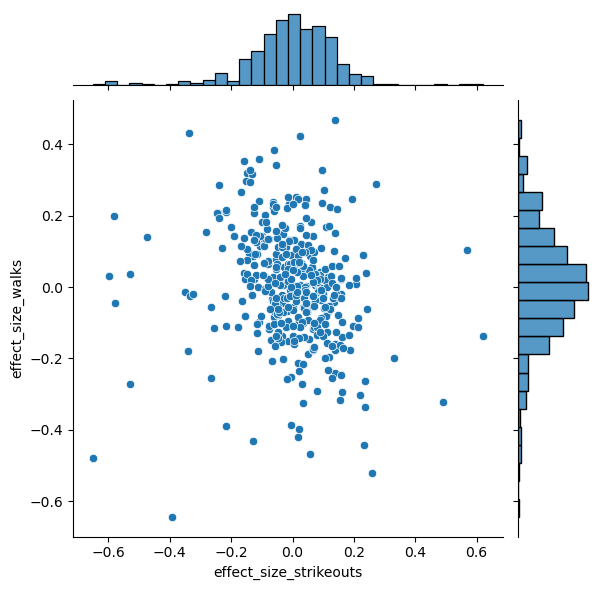

In [30]:
sns.jointplot(data=umpire_mean_stats, x='effect_size_strikeouts', y='effect_size_walks');

In [31]:
umpire_mean_stats['num_games'] = gb.size()

In [32]:
umpire_mean_stats['num_games']

hp_umpire_id
addir901    145
andeo901     62
anthm901    238
ashfe901    205
bacce901     83
           ... 
wolcq901    277
wolfj901    683
woodt901    113
younl901    719
zimmc101    103
Name: num_games, Length: 396, dtype: int64

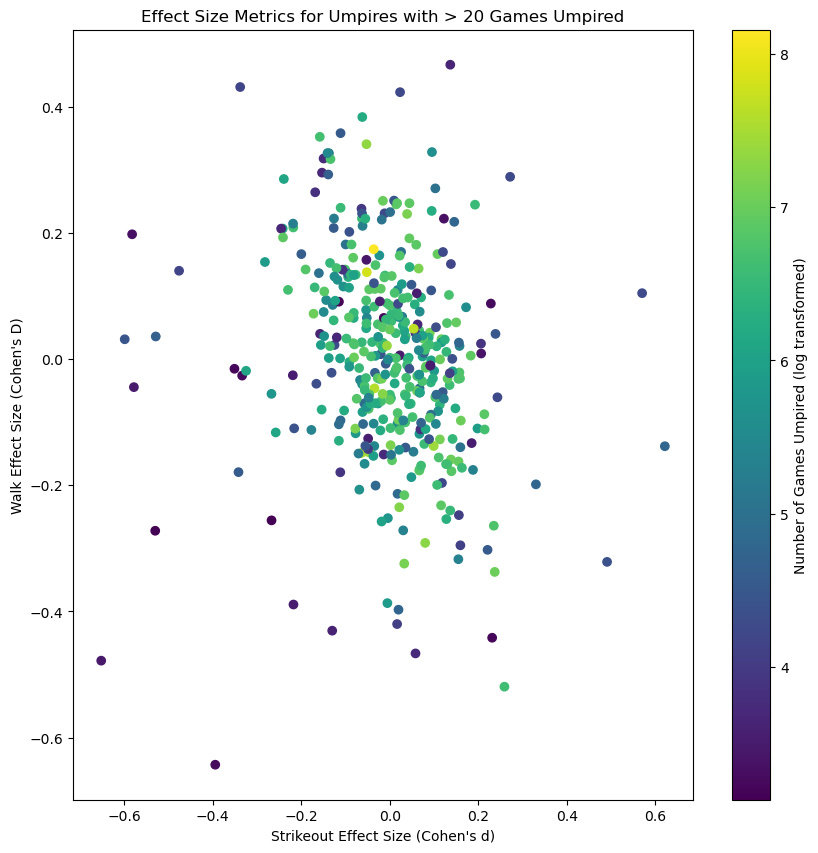

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
colorm3 = ax.scatter(x=umpire_mean_stats['effect_size_strikeouts'], y=umpire_mean_stats['effect_size_walks'], c=np.log(umpire_mean_stats['num_games']+1))
ax.set_xlabel("Strikeout Effect Size (Cohen's d)")
ax.set_ylabel("Walk Effect Size (Cohen's D)")
ax.set_title('Effect Size Metrics for Umpires with > 20 Games Umpired')
fig.colorbar(colorm3, label='Number of Games Umpired (log transformed)')


In [204]:
umpire_mean_stats.sort_values(by='effect_size_walks',ascending=False)

strikeouts     walks first_game  last_game  \
hp_umpire_id                                               
powej901        5.473684  4.710526 1923-09-14 1933-09-12   
hassj901        7.562500  3.796875 1903-04-20 1903-09-14   
conwj901        6.797101  4.014493 1906-04-13 1906-10-04   
byrol901        7.379310  4.659229 1913-05-24 1919-09-26   
parkg901        7.376344  5.763441 1936-09-20 1938-09-29   
...                  ...       ...        ...        ...   
donom901        5.666667  7.541667 1930-04-20 1930-09-07   
higgs901       12.756098  8.317073 2000-04-25 2003-07-08   
mcgre901        9.290323  7.193548 1913-06-04 1913-08-26   
hurle901        8.473046  8.652291 1947-04-21 1965-09-29   
fergb101        2.280000  2.560000 1871-09-09 1874-10-06   

              effect_size_strikeouts  effect_size_walks  num_games  
hp_umpire_id                                                        
powej901                    0.136808           0.467261         38  
hassj901                   -0.337582           0.431902         64  
conwj901                    0.023407           0.423737         69  
byrol901                   -0.061874           0.384278        493  
parkg901                   -0.110954           0.358712         93  
...                              ...                ...        ...  
donom901                    0.231367          -0.441686         24  
higgs901                    0.058297          -0.466536         41  
mcgre901                   -0.651378          -0.478036         31  
hurle901                    0.259132          -0.519322        742  
fergb101                   -0.393865          -0.643086         25  

[396 rows x 7 columns]

In [205]:
data_opt

date  number_of_game day_of_week v_name v_league  v_game_number  \
0    1871-05-04               0         Thu    CL1      NaN              1   
1    1871-05-05               0         Fri    BS1      NaN              1   
2    1871-05-06               0         Sat    CL1      NaN              2   
3    1871-05-08               0         Mon    CL1      NaN              3   
4    1871-05-09               0         Tue    BS1      NaN              2   
...         ...             ...         ...    ...      ...            ...   
2425 2023-10-01               0         Sun    SDN       NL            162   
2426 2023-10-01               0         Sun    CLE       AL            162   
2427 2023-10-01               0         Sun    NYA       AL            162   
2428 2023-10-01               0         Sun    TEX       AL            162   
2429 2023-10-01               0         Sun    TBA       AL            162   

     h_name h_league  h_game_number  v_score  h_score  length_outs day_night  \
0       FW1      NaN              1        0        2         54.0         D   
1       WS3      NaN              1       20       18         54.0         D   
2       RC1      NaN              1       12        4         54.0         D   
3       CH1      NaN              1       12       14         54.0         D   
4       TRO      NaN              1        9        5         54.0         D   
...     ...      ...            ...      ...      ...          ...       ...   
2425    CHA       AL            162        2        1         66.0         D   
2426    DET       AL            162        2        5         51.0         D   
2427    KCA       AL            162        2        5         51.0         D   
2428    SEA       AL            162        0        1         51.0         D   
2429    TOR       AL            162       12        8         54.0         D   

     completion forefeit protest park_id  attendance  length_minutes  \
0           NaN      NaN     NaN   FOR01       200.0           120.0   
1           NaN      NaN     NaN   WAS01      5000.0           145.0   
2           NaN      NaN     NaN   RCK01      1000.0           140.0   
3           NaN      NaN     NaN   CHI01      5000.0           150.0   
4           NaN      NaN     NaN   TRO01      3250.0           145.0   
...         ...      ...     ...     ...         ...             ...   
2425        NaN      NaN     NaN   CHI12     20588.0           187.0   
2426        NaN      NaN     NaN   DET05     41425.0           148.0   
2427        NaN      NaN     NaN   KAN06     20662.0           144.0   
2428        NaN      NaN     NaN   SEA03     43997.0           121.0   
2429        NaN      NaN     NaN   TOR02     42058.0           167.0   

     v_line_score h_line_score  v_at_bats  v_hits  v_doubles  v_triples  \
0       000000000    010010000       30.0     4.0        1.0        0.0   
1       107000435    640113030       41.0    13.0        1.0        2.0   
2       610020003    010020100       49.0    11.0        1.0        1.0   
3       101403111    077000000       46.0    15.0        2.0        1.0   
4       000002232    101003000       46.0    17.0        4.0        1.0   
...           ...          ...        ...     ...        ...        ...   
2425  00000000011  00000000010       36.0     7.0        1.0        0.0   
2426    000110000    11102000x       33.0     5.0        1.0        0.0   
2427    000002000    02021000x       32.0     7.0        3.0        0.0   
2428    000000000    00010000x       30.0     4.0        1.0        0.0   
2429    170111100    030003110       43.0    16.0        4.0        0.0   

      v_homeruns  v_rbi  v_sacrifice_hits  v_sacrifice_flies  v_hit_by_pitch  \
0            0.0    0.0               0.0                0.0             0.0   
1            0.0   13.0               0.0                0.0             0.0   
2            0.0    8.0               0.0                0.0             0.0   
3            2.0   10.0    

### Baseball Scorigami

In [206]:
def make_scorigami_frame(df):
    game_scores = df['h_score'].astype('str') +'-'+ df['v_score'].astype('str')
    scorigami_data = pd.DataFrame(game_scores.unique(), columns=['score'])
    scorigami_data[['h_score','v_score']] = pd.DataFrame(scorigami_data['score'].str.split('-').tolist(), index=scorigami_data.index).astype('int')
    scorigami_data.set_index('score', inplace=True)
    scorigami_data['counts'] = game_scores.value_counts(sort=False)

    return scorigami_data

def make_scorigami_pivot(df):
    scorigami_pivot = df.pivot(index='v_score', columns='h_score', values='counts').fillna(0)
    scorigami_pivot.sort_index(axis=1, inplace=True)
    oohs = np.zeros((50, 50))
    oohs = pd.DataFrame(oohs)
    oohs.index.name = 'v_score'
    oohs.columns.name = 'h_score'
    oohs.loc[scorigami_pivot.index, scorigami_pivot.columns] = scorigami_pivot
    return oohs

In [207]:
scorigami_data = make_scorigami_frame(data_opt)

In [208]:
scorigami_pivot = make_scorigami_pivot(scorigami_data)

In [209]:
# Define Custom Colormap
cmap = plt.cm.plasma
num_bins = 14
colors = cmap(np.linspace(0, 1, num_bins))
colors[0] = np.array([0, 0, 0, 1], dtype=float) # We want to be able to easily distinguish 1s and 0s. 
cmap = LinearSegmentedColormap.from_list("inferno", colors, N=num_bins)
boundaries = [0,1,2,4,8,16,32,64,128,256,512,1024, 2048, 4096, 8192]
norm=pltc.BoundaryNorm(boundaries, cmap.N, clip=True)

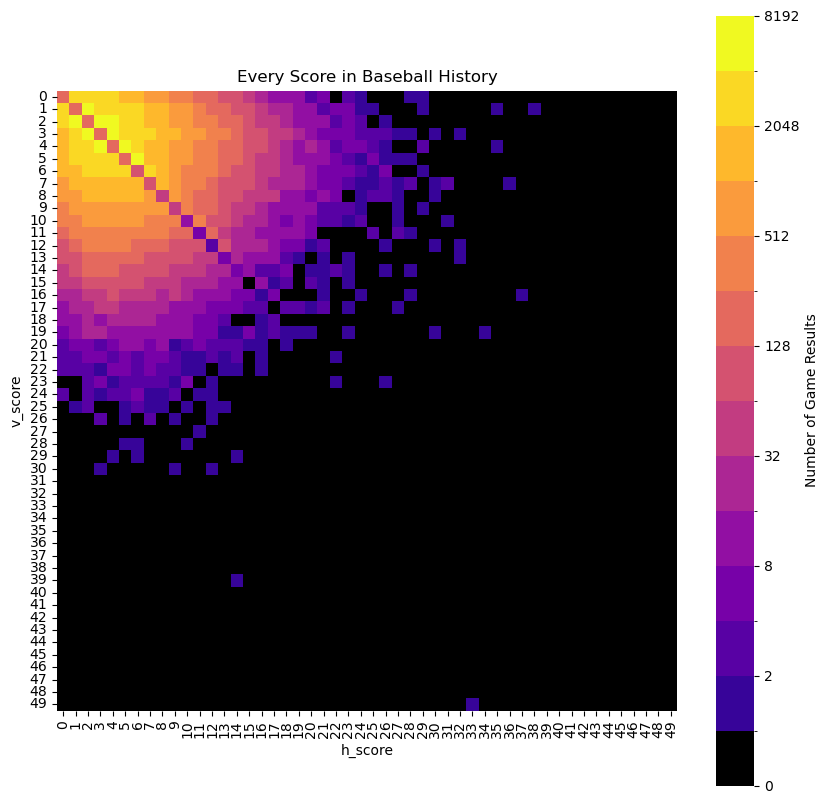

In [213]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = sns.heatmap(scorigami_pivot, cmap=cmap, norm=norm, square=True, xticklabels=scorigami_pivot.index.values, yticklabels=scorigami_pivot.index.values, cbar_kws={'label':'Number of Game Results'})
ax.set_title('Every Score in Baseball History');

In [214]:
ties = data_opt[data_opt['winning_margin'] == 0]

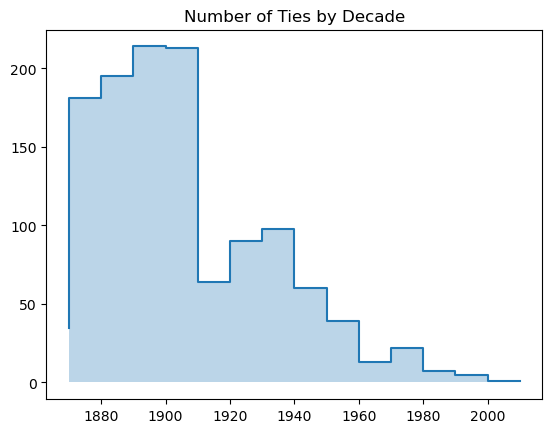

In [215]:
decade_ties = ties.groupby((ties.set_index('date').index.year//10) * 10).size()
plt.fill_between(x=decade_ties.index, y1=decade_ties, alpha=0.3, step='pre')
plt.plot(decade_ties, drawstyle='steps')
plt.title('Number of Ties by Decade');

### Baseball Over Time

#### Low-dimensional embedding with UMAP and HDBSCAN Clustering

In [198]:
pd.set_option('display.max_columns', 200)

In [246]:
# Feature Selection
def create_features_targets(features=['length_outs', 'total_score', 'winning_margin', 'hits', 'doubles', 'triples', 'homeruns', 'rbi', 'walks', 'strikeouts', 'stolen_bases', 'errors', 'double_plays'], grouped=None, filter_pre_history=False):
    feature_data = data_opt.loc[:, ['date', *features]].copy()
    if filter_pre_history:
        feature_data = feature_data[feature_data['date'] > '1900-01-01']
    if grouped is not None:
        # To get a more consistent view of our features, we can aggregate our data 
        feature_data = feature_data.set_index('date').groupby(pd.Grouper('date', freq=grouped)).mean()
        feature_data = feature_data.reset_index()
    feature_data = pd.merge(feature_data.set_index('date'), era_mapping, how='inner', on='date')
    feature_data = feature_data.dropna()
    X = feature_data.loc[:, features].values
    y = feature_data.loc[:, 'era'].values
    return feature_data, X, y

In [247]:
feature_df, X, y = create_features_targets(grouped='D', filter_pre_history=True)
X.shape, y.shape

((21040, 13), (21040,))

In [249]:
# Feature Scaling
X = StandardScaler().fit_transform(X)

In [250]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.85, svd_solver='full')
pcs = pca.fit_transform(X)

principal_df = pd.DataFrame(pcs, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
feature_df = pd.concat([feature_df, principal_df.set_index(feature_df.index)], axis=1)

In [265]:
cluster_embedding = umap.UMAP(
    n_neighbors=90,
    min_dist=0.0,
    n_components=5,
).fit_transform(X)
cluster_embedding.shape

(21040, 5)

In [266]:
reducer = umap.UMAP()
viz_embedding = reducer.fit_transform(X)
viz_embedding.shape

(21040, 2)

In [267]:
for component in range(cluster_embedding.shape[1]):
    feature_df[f'cluster_umap_{component + 1}'] = cluster_embedding[:, component]

In [268]:
feature_df['umap_1'] = viz_embedding[:, 0]
feature_df['umap_2'] = viz_embedding[:, 1]

In [269]:
hdbscan = HDBSCAN(
    min_samples=5,
    min_cluster_size=500,
)
hdbscan_labels = hdbscan.fit_predict(cluster_embedding)
feature_df['hdbscan_labels'] = hdbscan_labels

In [270]:
feature_df

length_outs  total_score  winning_margin       hits   doubles  \
date                                                                        
1901-04-18    54.000000    19.000000        5.000000  29.000000  6.000000   
1901-04-19    52.000000    11.333333        5.333333  21.333333  2.666667   
1901-04-20    52.500000    13.000000        2.000000  20.000000  1.500000   
1901-04-21    51.000000    17.000000        7.000000  19.000000  1.000000   
1901-04-22    51.000000    12.000000        6.000000  17.000000  4.000000   
...                 ...          ...             ...        ...       ...   
2023-09-27    53.312500     7.875000        3.875000  16.062500  3.250000   
2023-09-28    51.454545     6.000000        2.909091  13.545455  2.454545   
2023-09-29    53.357143    10.071429        4.357143  17.500000  3.214286   
2023-09-30    53.062500     9.937500        4.187500  18.875000  3.875000   
2023-10-01    54.066667     7.933333        3.266667  15.000000  2.933333   

             triples  homeruns        rbi     walks  strikeouts  stolen_bases  \
date                                                                            
1901-04-18  5.000000  0.000000  16.000000  8.000000   10.000000      4.000000   
1901-04-19  2.000000  1.000000   9.333333  5.000000    9.000000      3.666667   
1901-04-20  4.000000  1.500000  11.500000  5.500000    8.500000      2.000000   
1901-04-21  5.000000  0.000000  11.000000  7.000000    4.000000      3.000000   
1901-04-22  1.000000  1.000000  11.000000  4.000000    7.000000      3.000000   
...              ...       ...        ...       ...         ...           ...   
2023-09-27  0.250000  2.312500   7.625000  6.062500   19.000000      1.687500   
2023-09-28  0.454545  1.727273   5.636364  5.363636   17.272727      1.181818   
2023-09-29  0.500000  3.000000   9.285714  6.714286   16.928571      1.571429   
2023-09-30  0.437500  1.937500   9.500000  6.875000   17.625000      1.375000   
2023-10-01  0.466667  1.800000   7.200000  6.533333   18.933333      2.000000   

              errors  double_plays                              era       PC1  \
date                                                                            
1901-04-18  4.000000      1.000000        Dead Ball Era (1901-1920)  5.322145   
1901-04-19  2.000000      2.000000        Dead Ball Era (1901-1920)  0.523347   
1901-04-20  5.000000      1.000000        Dead Ball Era (1901-1920) -0.481239   
1901-04-21  3.000000      0.000000        Dead Ball Era (1901-1920)  0.048389   
1901-04-22  5.000000      0.000000        Dead Ball Era (1901-1920) -0.103538   
...              ...           ...                              ...       ...   
2023-09-27  0.687500      1.562500  Contemporary Era (2005-Present)  0.603524   
2023-09-28  1.090909      1.636364  Contemporary Era (2005-Present) -1.670415   
2023-09-29  1.500000      1.928571  Contemporary Era (2005-Present)  2.039974   
2023-09-30  1.125000      1.250000  Contemporary Era (2005-Present)  2.038392   
2023-10-01  1.200000      1.066667  Contemporary Era (2005-Present) -0.388843   

                  PC2       PC3       PC4       PC5       PC6       PC7  \
date                                                                      
1901-04-18  11.431738 -0.376486 -2.816969  1.147796  2.619400  1.810044   
1901-04-19   3.890486 -1.432841 -0.564939 -0.569378 -1.260462  0.378534   
1901-04-20   6.389235 -0.235911 -0.577893  0.693125  3.519090  3.197587   
1901-04-21   9.392275 -3.051797 -0.326291 -2.002510  2.929038  5.972343   
1901-04-22   4.293323 -4.232042 -2.272465 -0.136211 -0.583938  0.300901   
...               ...       ...       ...       ...       ...       ...   
2023-09-27  -2.554747 -1.292929 -1.342310 -0.271078 -0.672434  0.127562   
2023-09-28  -2.882547 -1.293574 -0.115924 -0.127259  0.078672  0.124165   
2023-09-29  -1.298488 -0.983957 -0.864131 -0.769243 -0.706592  0.351084   
2023-09-30  -0.966246 -1.376160 -1.401109 -0.020745  0.034916  0.245087   
20

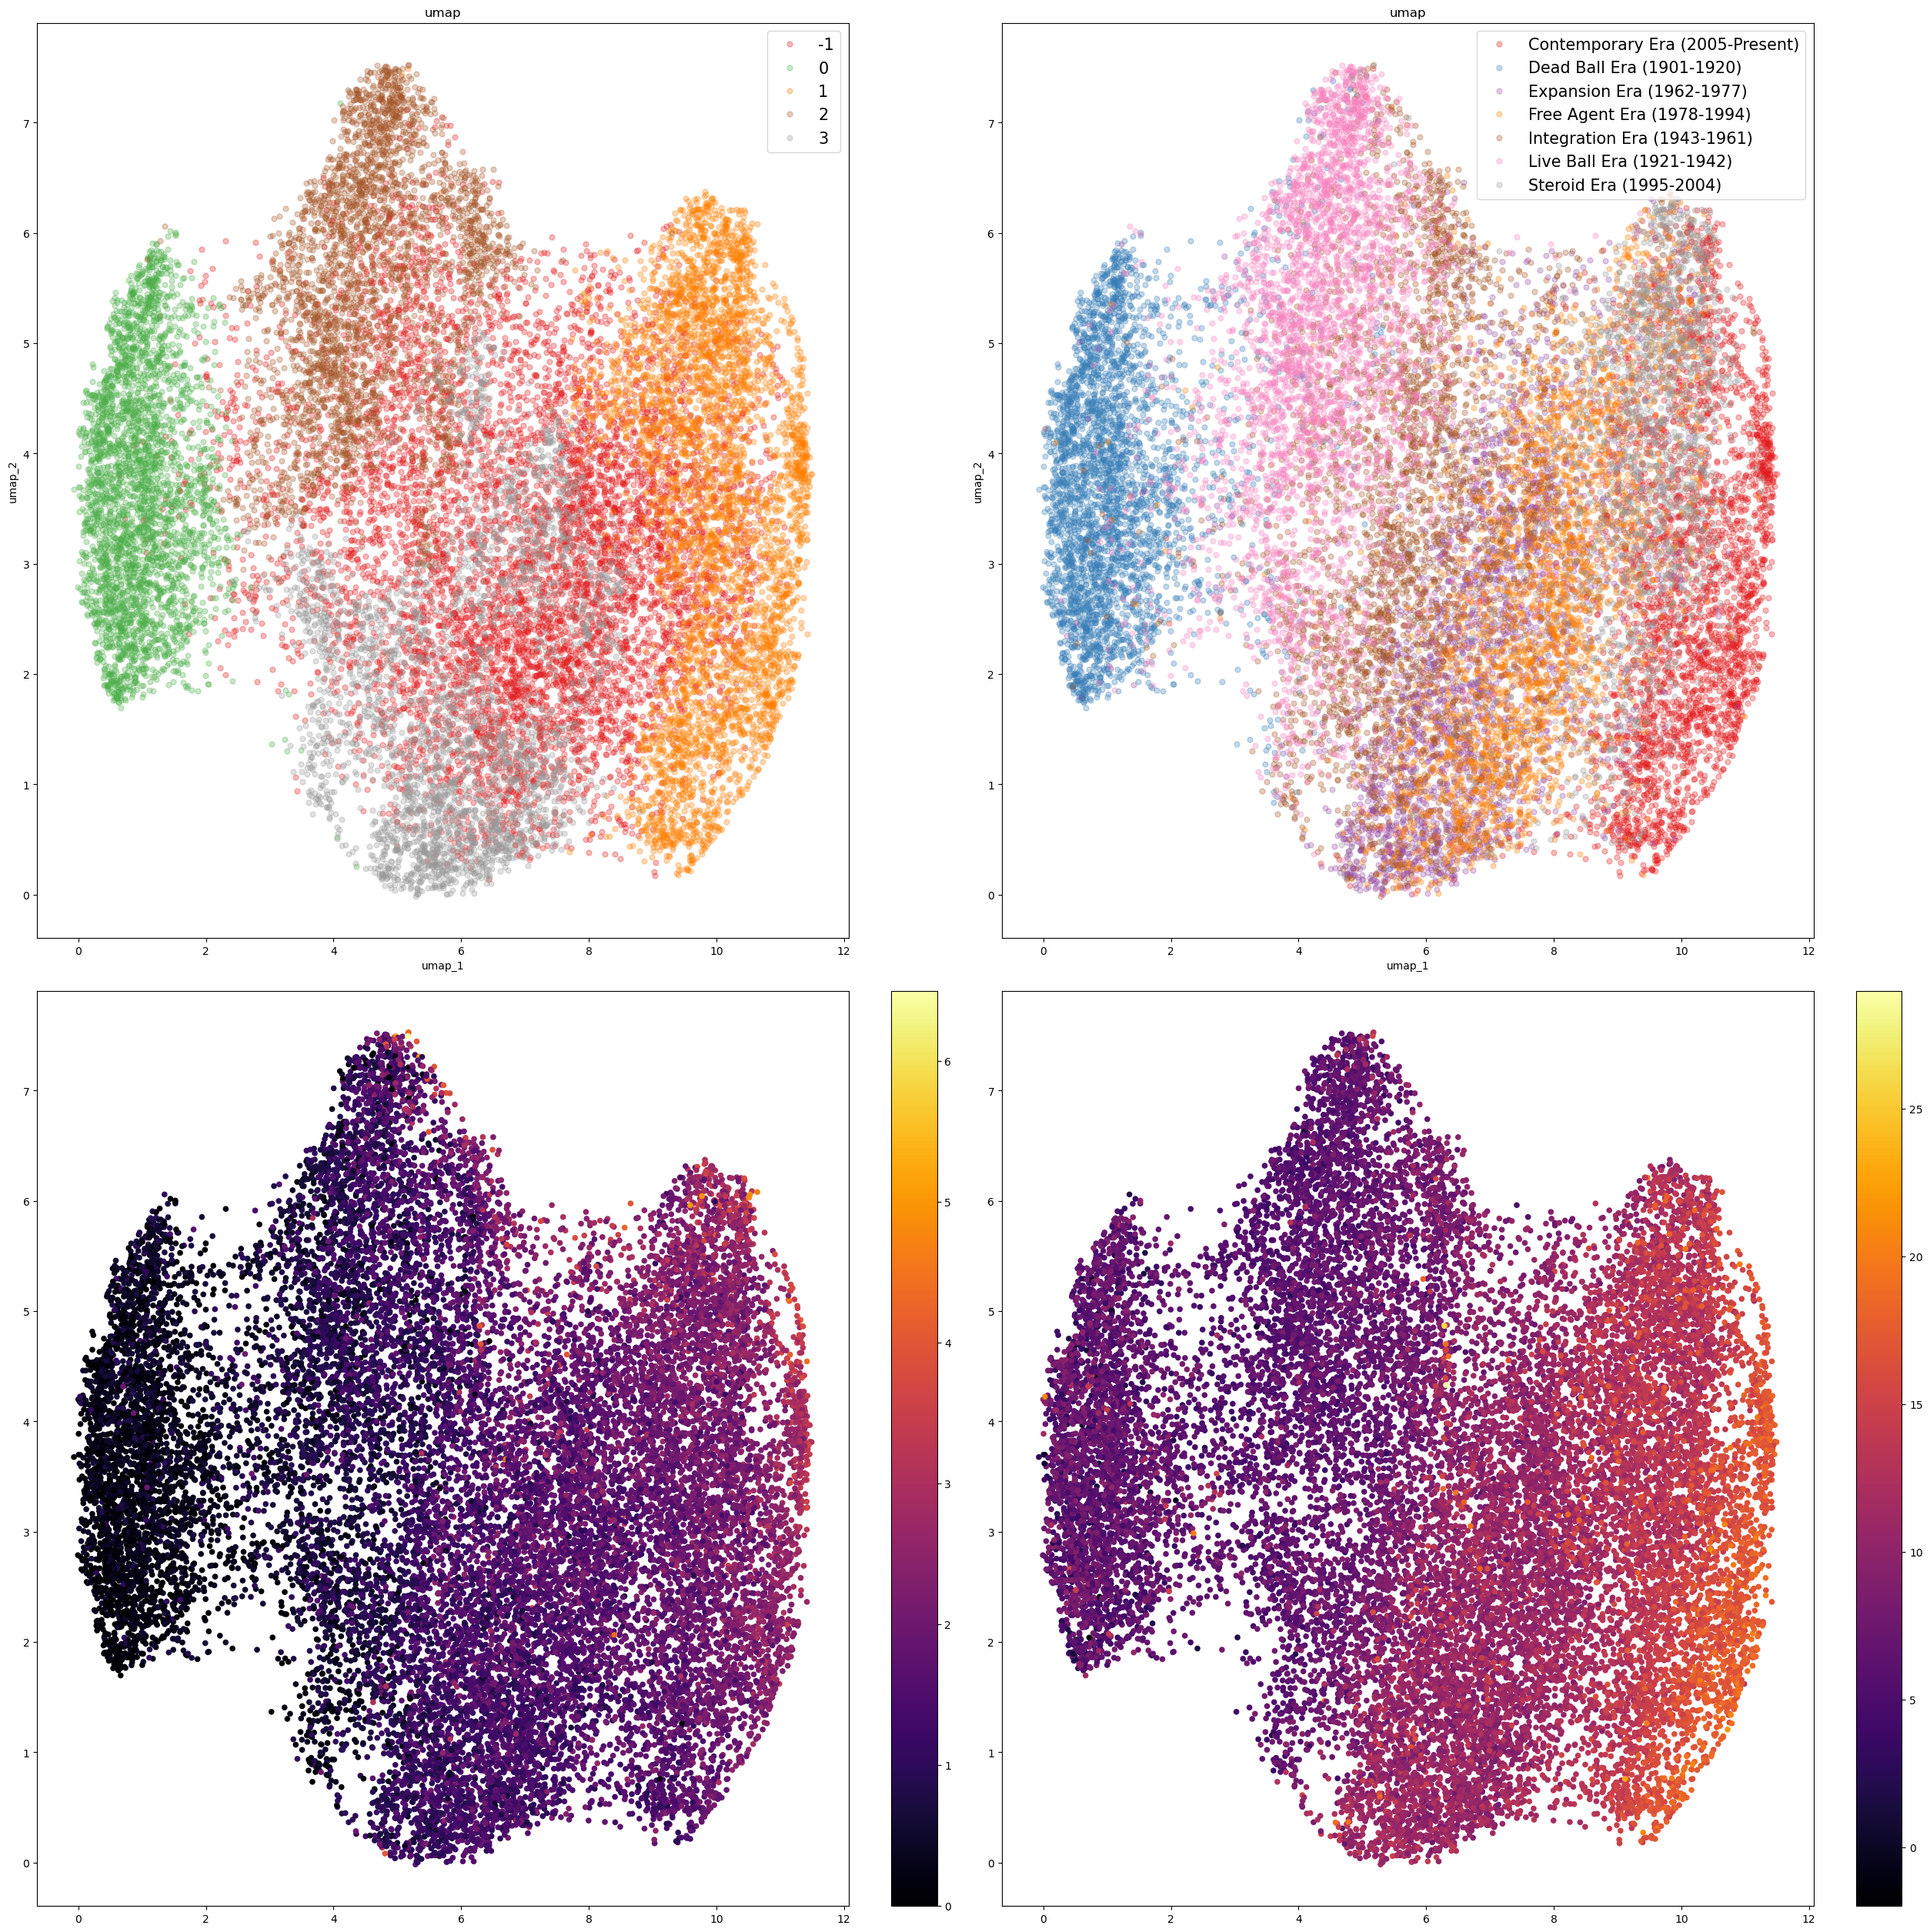

In [288]:
fig, axes = plt.subplots(2, 2, figsize=(25,25), layout='constrained')


for pc in range(2):
    targets = np.unique(hdbscan_labels) if pc == 0 else np.unique(y)
    label_col = 'hdbscan_labels' if pc==0 else 'era'
    clrs = cm.Set1(np.linspace(0,1,len(targets)))
    axes[0][pc].set_title(f'umap')
    axes[0][pc].set_xlabel(f'umap_1')
    axes[0][pc].set_ylabel(f'umap_2')

    for t, c in zip(targets, clrs):
        rows_idx = feature_df.loc[:, label_col] == t
        axes[0][pc].plot(feature_df.loc[rows_idx, f'umap_1'],
                feature_df.loc[rows_idx, f'umap_2'],
                'o',
                c=c, alpha=0.3, markersize=5)
    axes[0][pc].legend(targets, fontsize=15)

colorm = axes[1][0].scatter(x=feature_df.loc[:, f'umap_1'], y=feature_df.loc[:, f'umap_2'], c=feature_df['homeruns'], cmap='inferno', s=20)
fig.colorbar(colorm, ax=axes[1][0])
colorm2 = axes[1][1].scatter(x=feature_df.loc[:, f'umap_1'], y=feature_df.loc[:, f'umap_2'], c=feature_df['strikeouts'], cmap='inferno', s=20)
fig.colorbar(colorm2, ax=axes[1][1]);

### Network Graph

In [29]:
import networkx as nx
from itertools import combinations

In [30]:
network_columns = data_opt.columns[data_opt.columns.str.contains('id') & data_opt.columns.str.contains('player')]
network_data = data_opt[network_columns]

In [31]:
columns = [f'player{i+1}' for i in range(9)]
teamv, teamh = network_data.loc[:, :'v_player_9_id'], network_data.loc[:, 'h_player_1_id':]
teamv.columns = columns
teamh.columns = columns
network_data = pd.concat([teamv, teamh])
network_data = network_data.drop_duplicates()
network_data = network_data.dropna()

In [32]:
graph = nx.Graph()

In [33]:
from collections import Counter

In [34]:
weighted_graph = nx.Graph()

In [35]:
edges = network_data.apply(combinations, args=(2,), axis=1).apply(list)
edges = [edge for combos in edges for edge in combos]

In [36]:
c = Counter(edges)
c = dict(c)

In [37]:
weighted_edges = [(r[0][0], r[0][1], r[1]) for r in list(c.items())]

In [38]:
weighted_graph.add_weighted_edges_from(weighted_edges)

In [39]:
player_metadata = pd.read_csv('./data/player_ids/biofile.csv')

In [60]:
player_metadata_filtered = player_metadata.loc[:, ['PLAYERID', 'BIRTH.COUNTRY', 'PLAY.DEBUT', 'HOF']]
player_metadata_filtered['PLAY.DEBUT'] = pd.to_datetime(player_metadata_filtered['PLAY.DEBUT'])
player_metadata_filtered['PLAY.DEBUT'] = player_metadata_filtered['PLAY.DEBUT'].dt.year
player_metadata_filtered = player_metadata_filtered.set_index('PLAYERID')
attrs = player_metadata_filtered.to_dict('index')

In [63]:
nx.set_node_attributes(weighted_graph, attrs)

In [64]:
nx.write_gexf(weighted_graph, 'weighted_graph.gexf')

In [1]:
import pandas as pd

data = {
    "A": [5, 6, 8, 9, 7],
    "B": ["Flamingo", "Zebra", "Cart", "Bucket", "Samantha"],
    "C": ["Some", "Alex", "Apple", 5, "Art"]
}

df = pd.DataFrame(data)

In [7]:
max_value = df[(df["B"].str.len() > 4) & (df["C"].str.startswith("A"))]["A"].max()

In [17]:
import pandas as pd

data = {
    "Receipt ID": ["124DC", "4442A", "222BZ", None, "5421T"],
    "Waiter/Waitress Name": ["Todd", None, "Lenny", "Jennifer", "Yazmin"],
    "Tip Amount": [12, 4, 3, 44, 29]
}

df = pd.DataFrame(data)

In [14]:
df["Receipt ID"] = df["Receipt ID"].fillna("Unknown")

In [19]:
df

Receipt ID Waiter/Waitress Name  Tip Amount
0      124DC                 Todd          12
1      4442A                 None           4
2      222BZ                Lenny           3
3       None             Jennifer          44
4      5421T               Yazmin          29

In [18]:
df.fillna({"Receipt ID": "Unknown"})

Receipt ID Waiter/Waitress Name  Tip Amount
0      124DC                 Todd          12
1      4442A                 None           4
2      222BZ                Lenny           3
3    Unknown             Jennifer          44
4      5421T               Yazmin          29